# Testing Data Generator

We test the generation of data according to extra information added. We can select the information by setting soil = True and coord = True to get 6 channels: temperature values, lat, lat2, lon, lon2 and land-sea mask. 

In [1]:
import sys
sys.path.insert(0,'/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/users/donayreholtz1/lossy-ml/')
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data

In [11]:
from collections import OrderedDict
import dask
from lossycomp.constants import Region, REGIONS
import xarray as xr
from lossycomp.plots import single_plot
dask.config.set(**{'array.slicing.split_large_chunks': False})
file = '/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/data/ECMWF/1979/*/temperature.nc'
maps = '/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/data/ECMWF/1979_single/*/land-sea-mask.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z,mean, std = data_preprocessing(file, var, region)

region = REGIONS[region]
soil = xr.open_mfdataset(maps, combine='by_coords')
soil = soil.sel(longitude=slice(region.min_lon,region.max_lon),
                    latitude=slice(region.min_lat,region.max_lat))
ds = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
ds.append(soil['lsm'].expand_dims({'level': generic_level}, 1))
soil_d = xr.concat(ds, 'level').transpose('time', 'latitude', 'longitude', 'level')
z["lsm"]=(['time', 'latitude', 'longitude', 'level'], soil_d)

train, test= split_data(z, 10, 10, 16, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

In [12]:
dg_train = DataGenerator(z, train, leads, mean, std, batch_size=10, load=True, coords = True, soil = True, standardize = False)

Loading data into RAM


In [13]:
data = dg_train.__getitem__(0)[0][0]

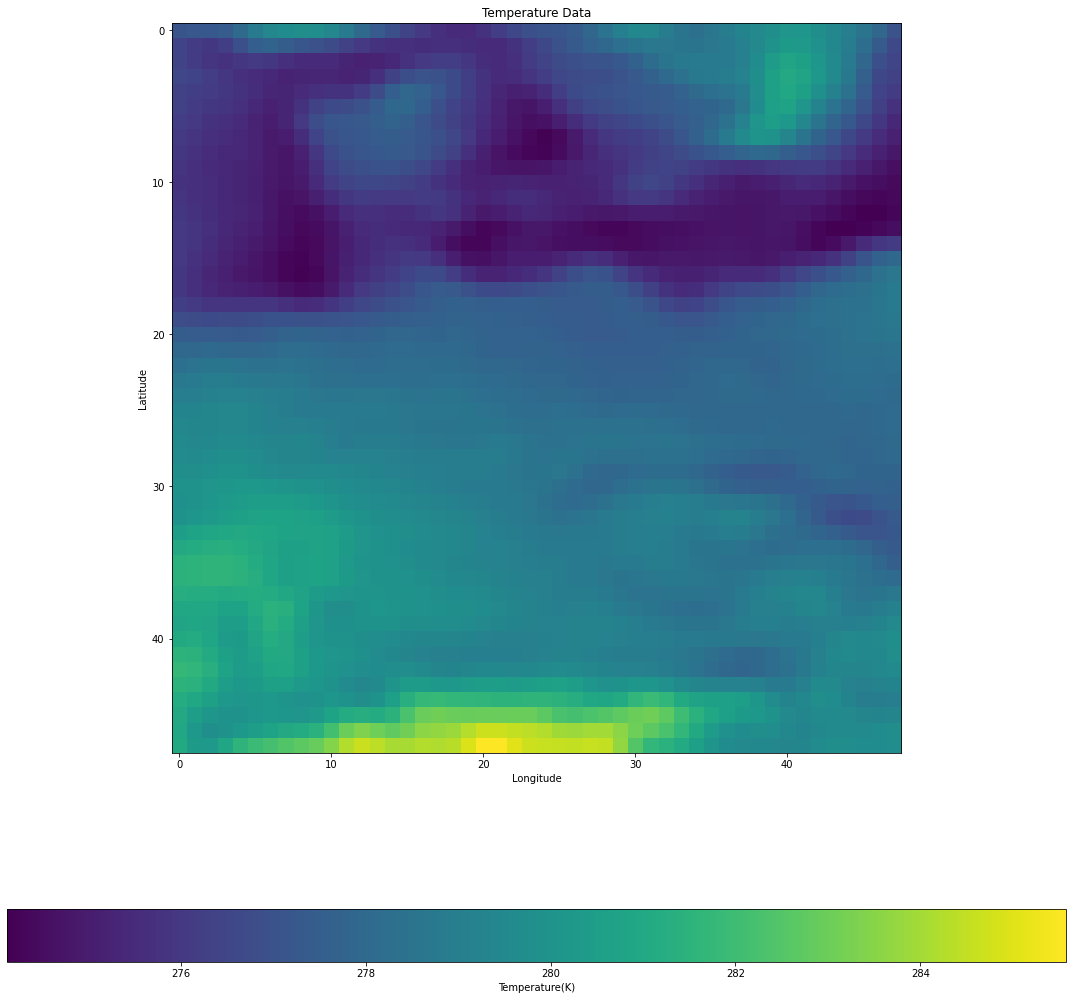

In [14]:
import numpy as np
data_r = np.expand_dims(data[:,:,:,0], axis=0)
data_r = np.expand_dims(data_r, axis=4)
single_plot(data_r, 0, "Temperature Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

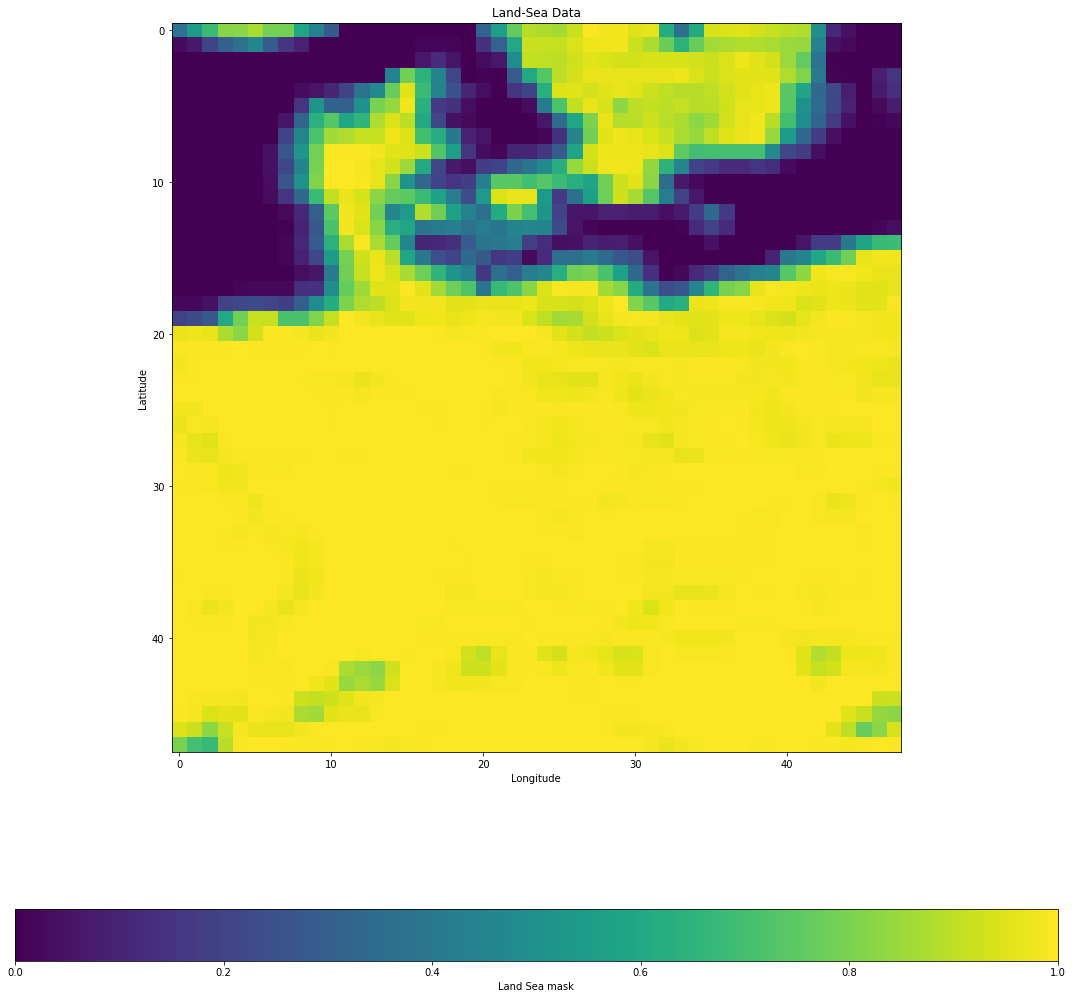

In [15]:
data_r = np.expand_dims(data[:,:,:,5], axis=0)
data_r = np.expand_dims(data_r, axis=4)
single_plot(data_r, 0, "Land-Sea Data", "Land Sea mask", data_r[0,0].min(), data_r[0,0].max())